# Deep Learning Course - Exercise 3

* Alon Mizrahi 312284706
* Nimrod Curtis 311230924

-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------

### Import

In [1]:
## To import google drive, write this code in code section of colab and run it
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import sys
import timeit
import os
from IPython.display import Image

# SVM
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision.utils import save_image

import warnings
warnings.filterwarnings('ignore')

### Globals

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f'Device: {device}')

Device: cuda


In [4]:
# seed
np.random.seed(5)
torch.manual_seed(5)

### Utils

In [ ]:
# class_mapping = {
#                  0: "T-shirt/Top",
#                  1: "Trouser",
#                  2: "Pullover",
#                  3: "Dress",
#                  4: "Coat", 
#                  5: "Sandal", 
#                  6: "Shirt",
#                  7: "Sneaker",
#                  8: "Bag",
#                  9: "Ankle Boot"
#                  }

# def output_label(label):
#     input = (label.item() if type(label) == torch.Tensor else label)
#     return class_mapping[input]

In [5]:
def load_mnist_dataset(batch_size = 100):

  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      # torchvision.transforms.Normalize(mean=0.3814, std=0.3994),
  ])

  root_dir = "../../OOP" 
  train = torchvision.datasets.FashionMNIST(root=root_dir, train=True,
                                                transform=transform, 
                                                download=True )

  test = torchvision.datasets.FashionMNIST(root=root_dir, train=False,
                                               transform=transform, 
                                               download=True )
  trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=batch_size)
  testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=batch_size)
  
  return trainloader, testloader

In [6]:
def load_mnist_dataset_svm(n_samples_for_class, model_vae):

  transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
  ])

  root_dir = "../../OOP" 
  train = torchvision.datasets.FashionMNIST(root=root_dir, train=True,
                                                transform=transform, 
                                                download=True )

  test = torchvision.datasets.FashionMNIST(root=root_dir, train=False,
                                               transform=transform, 
                                               download=True )
  
  
  test_n_sam = int(np.round(n_samples_for_class/2,0))
  if (n_samples_for_class == 3000): test_n_sam = int(np.round(n_samples_for_class/3,0))

  tr_labels = train.targets.numpy().astype(int)
  te_labels = test.targets.numpy().astype(int)

  # Initialize an empty list to store the reduced datasets
  reduced_train_data = []
  reduced_encode_train_data = []
  reduced_test_data = []
  reduced_encode_test_data = []

  # Iterate over each unique label
  for label in np.unique(tr_labels):
      indices = np.where(tr_labels == label)[0]
      selected_indices = np.random.choice(indices, size=n_samples_for_class, replace=False)
      reduced_encode_train_data.extend(train.data[selected_indices])
      reduced_train_data.extend(train.data[selected_indices].view(-1, 28 * 28))

  reduced_encode_train_data = torch.stack([torch.tensor(arr) for arr in reduced_encode_train_data])
  reduced_train_data = torch.stack([torch.tensor(arr) for arr in reduced_train_data])
  reduced_encode_train_data = encode_set(reduced_encode_train_data, model_vae)
  reduced_train_data = reduced_train_data.detach().numpy()
  reduced_train_labels = np.repeat(np.arange(10), n_samples_for_class)

  for label in np.unique(te_labels):
    indices = np.where(te_labels == label)[0]
    s = indices.shape
    selected_indices = np.random.choice(indices, size=s, replace=False) #  size=test_n_sam,
    reduced_encode_test_data.extend(test.data[selected_indices])
    reduced_test_data.extend(test.data[selected_indices].view(-1, 28 * 28))

  reduced_encode_test_data = torch.stack([torch.tensor(arr) for arr in reduced_encode_test_data])
  reduced_test_data = torch.stack([torch.tensor(arr) for arr in reduced_test_data])
  reduced_encode_test_data = encode_set(reduced_encode_test_data, model_vae)
  reduced_test_data = reduced_test_data.detach().numpy()
  reduced_test_labels = np.repeat(np.arange(10), s) #test_n_sam)

  
  return reduced_train_data, reduced_encode_train_data , reduced_train_labels, reduced_test_data, reduced_encode_test_data, reduced_test_labels

In [7]:
def test(epoch, batch_size, model, optimizer, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                # save_image(comparison.cpu(),
                #          '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_3_VAE_GAN_WGAN/312284706_311230924_ex3/results_section4/' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss (VAE): {:.4f}'.format(test_loss))

    return model


In [8]:
def fit_and_check_svc(svc, x_train, y_train, x_test, y_test, n_samples, data_kind):
  svc.fit(x_train , y_train)
  y_pred = svc.predict(x_test)
  print(f"Accuracy with {n_samples} labels for {data_kind} data:",np.round(metrics.accuracy_score(y_test, y_pred),5)*100,"%")
  cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
  disp.plot(cmap=plt.cm.Blues,values_format='g') 
  plt.show()
  return svc

### Model - VAE 
(implementation from the paper: 'Semi-supervised Learning with Deep Generative Models')

In [9]:
class VAE_M1(nn.Module):
    def __init__(self, InpOup = 784, dim_2 = 600, z_dim = 50):
        super(VAE_M1, self).__init__()
        self.fc1 = nn.Linear(InpOup, dim_2)
        self.bn1 = nn.LayerNorm(dim_2)
        self.fc2 = nn.Linear(dim_2,dim_2)
        self.fc31 = nn.Linear(dim_2, z_dim)
        self.fc32 = nn.Linear(dim_2, z_dim)
        self.fc4 = nn.Linear(z_dim, dim_2)
        self.fc5 = nn.Linear(dim_2,dim_2)
        self.fc6 = nn.Linear(dim_2, InpOup)

    def encode(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc31(x), self.fc32(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std) # returns random [0,1] in size same as std
        return mu + eps*std # sampling operation

    def decode(self, z):
        z = self.fc4(z)
        z = F.relu(z)
        z = self.fc5(z)
        z = F.relu(z)
        z = self.fc6(z)
        return torch.sigmoid(z)
        # return F.relu(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def encode_set(data, model):
    data = torch.unsqueeze(data, dim=1)
    data = data.to(device)
    with torch.no_grad():
      _, encoded, _ = model(data.float())

    return encoded.cpu().detach().numpy()

def loss_function(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence losses summed over all elements and batch
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Train

In [10]:
def train(epoch, epochs, model, optimizer, train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return model

### Main Function

In [11]:
def main(n_samples, PATH, is_training_VAE = True, is_training_SVM = True, save_vae = False, save_svm = False):
  # seed
  np.random.seed(5)
  torch.manual_seed(5)

  # hyperparameters
  batch_size = 100
  lr = 3e-4
  epochs = 25

  # net-params
  n_classes = 10
  z_dim = 50
  inpoup = 784
  dim2 = 600

  # data 
  train_loader, test_loader = load_mnist_dataset(batch_size = 100)

  # VAE model
  model = VAE_M1(inpoup, dim2, z_dim)
  model = model.to(device)
  
  # train / load + test to VAE
  optimizer = optim.Adam(model.parameters(), lr=lr)
  if is_training_VAE:
    for epoch in range(1, epochs+1):
      model = train(epoch, epochs, model, optimizer, train_loader)
      model = test(epoch, batch_size, model, optimizer, test_loader)
  else:
    model.load_state_dict(torch.load(PATH+'VAE_01', map_location=device))
    model = test(1, batch_size, model, optimizer, test_loader)

  # save   
  if save_vae:
    torch.save(model.state_dict(), PATH+'VAE_01')


  # train / load + test to SVM
  n_samples_for_class = n_samples # 100, 600, 1000, 3000
  file_name = 'svc_model_'+str(n_samples)

  # SVM model
  if is_training_SVM:
    # svc_model_reg = SVC(kernel='rbf', gamma='scale')
    svc_model_en = SVC(kernel='rbf', gamma='scale') 
  else: 
    # svc_model_reg = pickle.load(open(PATH+file_name+'.sav', 'rb'))
    svc_model_en = pickle.load(open(PATH+file_name+'encoded'+'.sav', 'rb'))

  # reduce, balance and encode data set
  reduced_train_data, reduced_encode_train_data , reduced_train_labels, reduced_test_data, reduced_encode_test_data, reduced_test_labels = load_mnist_dataset_svm(n_samples_for_class, model)

  # svc_model_reg = fit_and_check_svc(svc_model_reg, reduced_train_data, reduced_train_labels, reduced_test_data, reduced_test_labels, n_samples_for_class, 'regular')
  svc_model_en = fit_and_check_svc(svc_model_en, reduced_encode_train_data, reduced_train_labels, reduced_encode_test_data, reduced_test_labels, n_samples_for_class, 'encoded')

  if save_svm:
    # pickle.dump(svc_model_reg, open(PATH+file_name+'.sav', 'wb'))
    pickle.dump(svc_model_en, open(PATH+file_name+'encoded'+'.sav', 'wb'))

  return 

In [ ]:
# save models --- 1 time
# PATH = '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_3_VAE_GAN_WGAN/312284706_311230924_ex3/models/'
# n_samples = [100, 600, 1000, 3000]
# is_training_VAE = True
# is_training_SVM = True
# save_vae = True
# save_svm = True

# for n_sam in n_samples:

#   main(n_sam, PATH, is_training_VAE, is_training_SVM, save_vae, save_svm)

#   is_training_VAE = False
#   save_vae = False


====> Test set loss (VAE): 239.6065
Accuracy with 100 labels for encoded data: 78.95 %


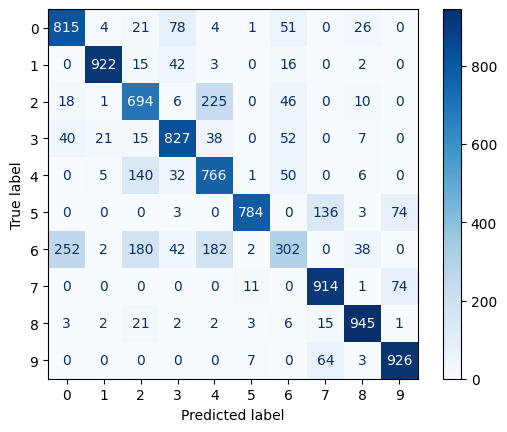

====> Test set loss (VAE): 239.6065
Accuracy with 600 labels for encoded data: 82.34 %


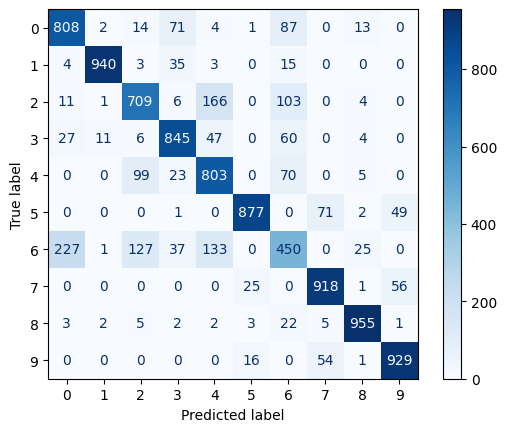

====> Test set loss (VAE): 239.6065
Accuracy with 1000 labels for encoded data: 83.07 %


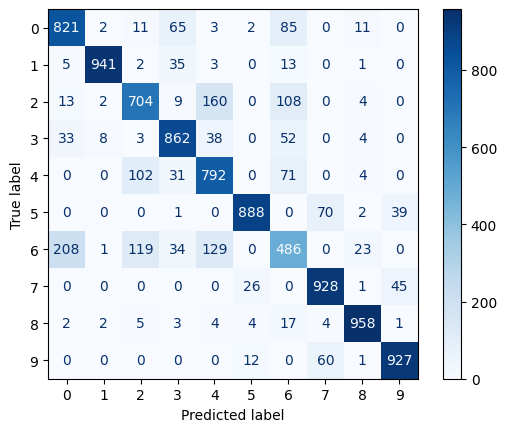

====> Test set loss (VAE): 239.6065
Accuracy with 3000 labels for encoded data: 84.25 %


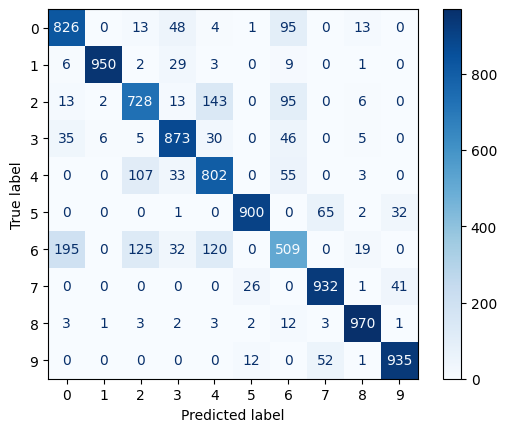

In [21]:
# check the saved models all test
# PATH = '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_3_VAE_GAN_WGAN/312284706_311230924_ex3/models/'
# n_samples = [100, 600, 1000, 3000]
# is_training_VAE, is_training_SVM, save_vae, save_svm  = False, False, False, False

# for n_sam in n_samples:
#   main(n_sam, PATH, is_training_VAE, is_training_SVM, save_vae, save_svm)

--------------------------------------------------------------------------
--------------------------------------------------------------------------


### For the Instructor
1. First set your relevant paths:
  - models dir

2. Then choose to train/load models :
  - Train new model (flag = 0)
  - Load Trained Model and Test it (flag = 1)
  - Load Trained Model VAE and Train new svm model and Test it (flag = 2)

3. Pick the number of samples for each class:
  - 100 
  - 600 
  - 1000 
  - 3000 

  Then run the cell after, good luck! 

4. Finally examine the data and inference the model!

In [19]:
# 1. 
# path to model dir
# # TODO
PATH= '/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning_Course/Exercises/EX_3_VAE_GAN_WGAN/312284706_311230924_ex3/models/'

# 2. 
# Train new model  -> flag = 0
# Load model -> flag = 1
# Train SVM only and load VAE flag = 2
flag = 1

# # 3.
n_samples = 100 # 100, 600, 1000, 3000


In [ ]:
if flag == 0:
  print(f"Start training of VAE and SVM models for {n_samples} samples ...")
  main(n_samples, PATH, True, True, False, False)

elif flag == 1:
  print(f"Loading of VAE and SVM models with {n_samples} samples ...")
  main(n_samples, PATH, False, False, False, False)

elif flag == 2:
  print(f"Loading of VAE model and training SVM model with {n_samples} samples ...")
  main(n_samples, PATH, False, True, False, False)